### 9.1.1 Working with CSKs

In [1]:
kB <- function(r, rmax) 
 {
  rnorm <- r/rmax
  k <- (1 - rnorm)*cos(pi*rnorm) + sin(pi*rnorm)/pi
  k <- k*(r < rmax)
 }

In [2]:
library(plgp)

Loading required package: mvtnorm

Loading required package: tgp



In [3]:
X <- matrix(seq(0, 10, length=2000), ncol=1)
D <- distance(X)

In [4]:
eps <- sqrt(.Machine$double.eps)  ## numerical stability
K <- exp(-D) + diag(eps, nrow(D))
K2 <- kB(sqrt(D), 2)
K1 <- kB(sqrt(D), 1)
K025 <- kB(sqrt(D), 0.25)
c(mean(K > 0), mean(K2 > 0), mean(K1 > 0), mean(K025 > 0))

[1] 1.0000000 0.3596000 0.1895500 0.0488875

In [5]:
library(Matrix)
c(system.time(chol(K))[3], 
  system.time(chol(Matrix(K2, sparse=TRUE)))[3],
  system.time(chol(Matrix(K1, sparse=TRUE)))[3], 
  system.time(chol(Matrix(K025, sparse=TRUE)))[3])

elapsed elapsed elapsed elapsed 
  0.037   0.257   0.106   0.075

In [6]:
set.seed(31231)
x <- c(1, 2, 4, 5, 6, 8, 9, 10)/11
n <- length(x)
D <- distance(as.matrix(x))
K <- exp(-5*sqrt(D)^1.5) + diag(eps, n)
library(mvtnorm)
y <- t(rmvnorm(1, sigma=K))

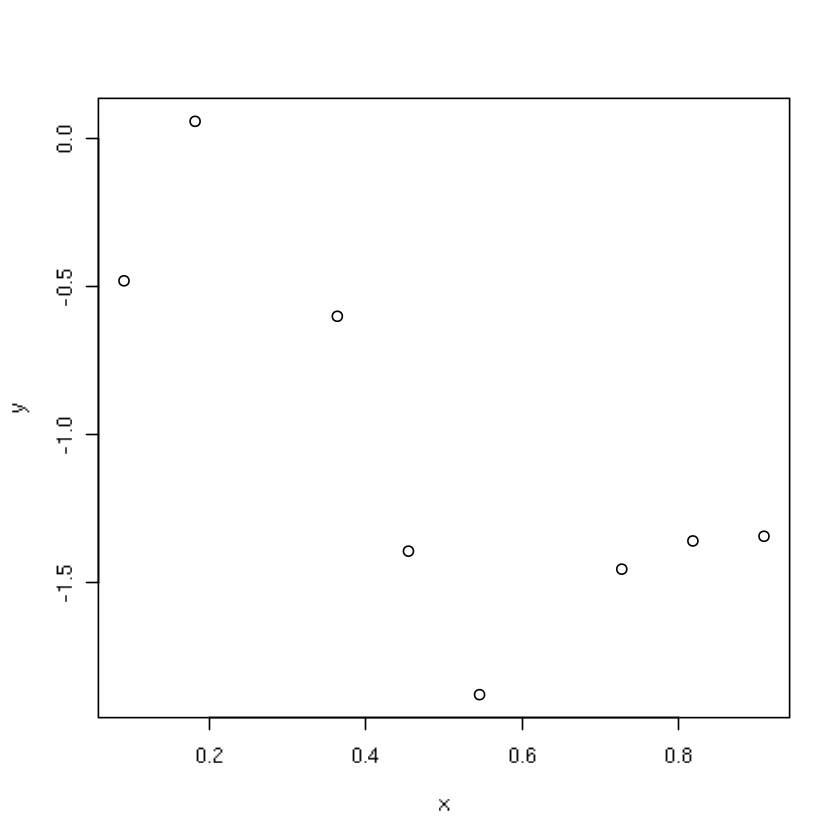

In [7]:
plot(x, y)

In [8]:
xx <- seq(0, 1, length=100)
DX <- distance(as.matrix(x), as.matrix(xx))
KX <- exp(-5*sqrt(DX)^1.5)
Ki <- solve(K)
m <- t(KX) %*% Ki %*% y
Sigma <- diag(1+eps, ncol(KX)) - t(KX) %*% Ki %*% KX
q1 <- qnorm(0.05, m, sqrt(diag(Sigma)))
q2 <- qnorm(0.95, m, sqrt(diag(Sigma)))

In [9]:
K01 <- kB(sqrt(D), 0.1)
KX01 <- kB(sqrt(DX), 0.1)
Ki01 <- solve(K01)
m01 <- t(KX01) %*% Ki01 %*% y
tau2 <- drop(t(y) %*% Ki01 %*% y)/n
Sigma01 <- tau2*(1 - t(KX01) %*% Ki01 %*% KX01)
q101 <- qnorm(0.05, m01, sqrt(diag(Sigma01)))
q201 <- qnorm(0.95, m01, sqrt(diag(Sigma01)))

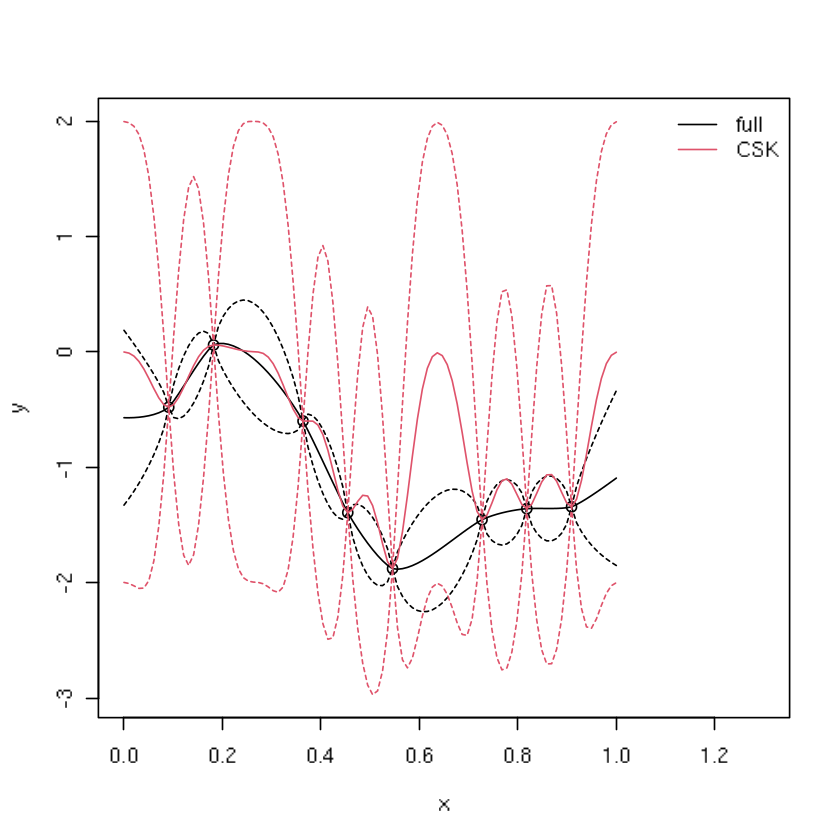

In [10]:
plot(x, y, xlim=c(0, 1.3), ylim=range(q101, q201))
lines(xx, m)
lines(xx, q1, lty=2)
lines(xx, q2, lty=2)
lines(xx, m01, col=2)
lines(xx, q101, col=2, lty=2)
lines(xx, q201, col=2, lty=2)
legend("topright", c("full", "CSK"), lty=1, col=1:2, bty="n")

### 9.1.2 Sharing load between mean and variance

In [11]:
install.packages("/root/SparseEm_0.2-2.tar.gz", repos=NULL, type="source")

In [12]:
library(SparseEm)

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:Matrix’:

    det


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve




In [13]:
leg01 <- legFun(0, 1)
degree <- 4
X <- leg01(x, terms=polySet(1, degree, 2, degree)) 
colnames(X) <- paste0("l", 0:(ncol(X) - 1))
X <- data.frame(X)
X

l0,l1,l2,l3,l4
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.4171325,1.1272739,-0.3756927,-0.5243494
1,-1.1022142,0.2402387,0.8209581,-1.2783963
1,-0.4723775,-0.8685553,0.9481768,0.3608360
1,-0.1574592,-1.0903141,0.3558148,1.0329212
1,0.1574592,-1.0903141,-0.3558148,1.0329212
1,0.7872958,-0.4250377,-1.1827363,-0.6390957
1,1.1022142,0.2402387,-0.8209581,-1.2783963
1,1.4171325,1.1272739,0.3756927,-0.5243494


In [14]:
lfit <- lm(y ~ . -1, data=X)
lfit


Call:
lm(formula = y ~ . - 1, data = X)

Coefficients:
     l0       l1       l2       l3       l4  
-1.1334  -0.3896  -0.0291   0.3601  -0.4448  


In [15]:
XX <- leg01(xx, terms=polySet(1, degree, 2, degree)) 
colnames(XX) <- paste0("l", 0:(ncol(X) - 1))
p <- predict(lfit, newdata=data.frame(XX), interval="prediction", level=0.9)

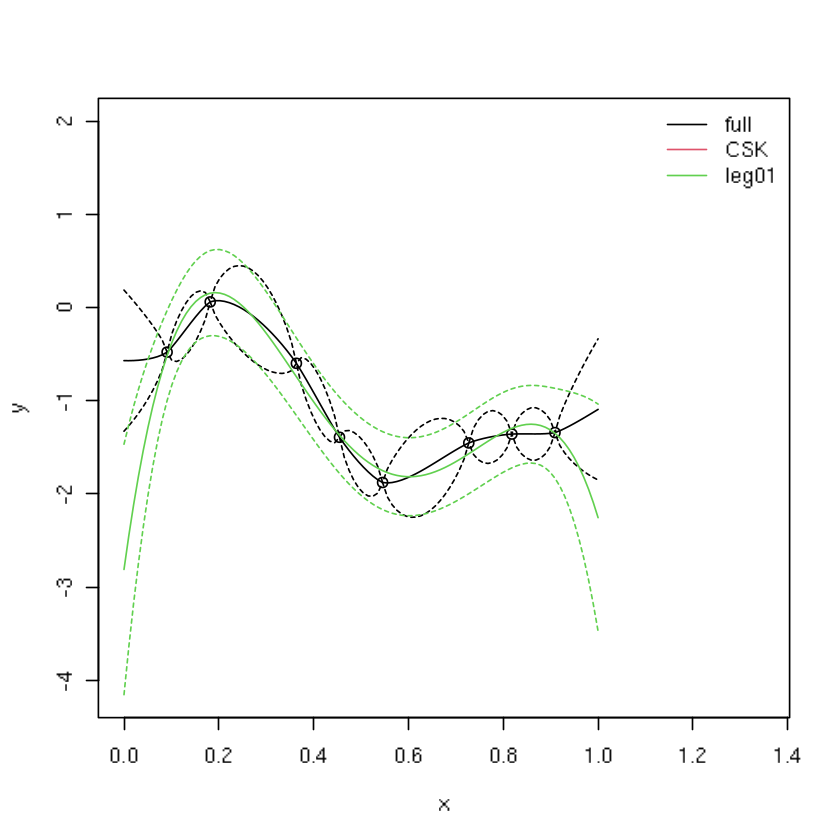

In [16]:
plot(x, y, xlim=c(0, 1.35), ylim=range(q101, q201, p[,2], p[,3]))
lines(xx, m)
lines(xx, q1, lty=2)
lines(xx, q2, lty=2)
# lines(xx, m01, col=2)
# lines(xx, q101, col=2, lty=2)
# lines(xx, q201, col=2, lty=2)
lines(xx, p[,1], col=3)
lines(xx, p[,2], col=3, lty=2)
lines(xx, p[,3], col=3, lty=2)
legend("topright", c("full", "CSK", "leg01"), lty=1, col=1:3, bty="n")

In [17]:
m2 <- t(KX01) %*% Ki01 %*% lfit$resid
tau22 <- drop(t(lfit$resid) %*% Ki01 %*% lfit$resid)/n
Sigma2 <- tau22*(1 - t(KX01) %*% Ki01 %*% KX01)

In [18]:
m2 <- p[,1] + m2
q12 <- qnorm(0.05, m2, sqrt(diag(Sigma2)))
q22 <- qnorm(0.95, m2, sqrt(diag(Sigma2)))

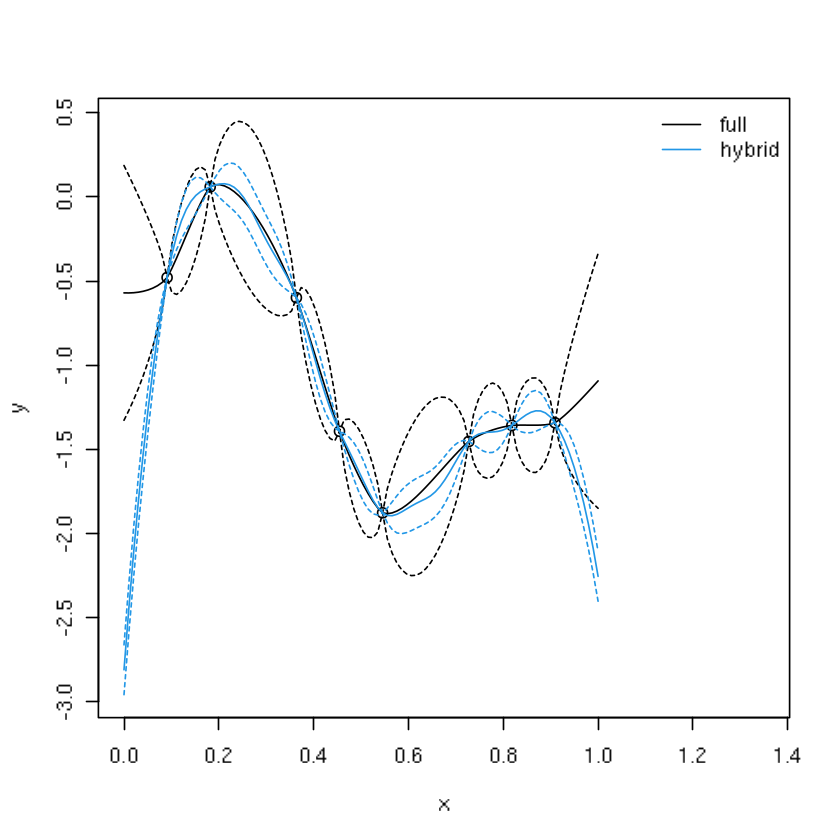

In [19]:
plot(x, y, xlim=c(0, 1.35), ylim=range(q1, q2, q12, q22))
lines(xx,m)
lines(xx, q1, lty=2)
lines(xx, q2, lty=2)
lines(xx, m2, col=4)
lines(xx, q12, col=4,lty=2)
lines(xx, q22, col=4,lty=2)
legend("topright", c("full", "hybrid"), lty=1, col=c(1,4), bty="n")

In [20]:
c(ideal=tau2, CSKresid=tau22)


ideal    CSKresid 
1.472997631 0.008098985

### 9.1.3 Practical Bayesian inference and UQ

In [21]:
borehole <- function(x)
 {
  rw <- x[1]*(0.15 - 0.05) + 0.05
  r <-  x[2]*(50000 - 100) + 100
  Tu <- x[3]*(115600 - 63070) + 63070
  Hu <- x[4]*(1110 - 990) + 990
  Tl <- x[5]*(116 - 63.1) + 63.1
  Hl <- x[6]*(820 - 700) + 700
  L <-  x[7]*(1680 - 1120) + 1120
  Kw <- x[8]*(12045 - 9855) + 9855
  m1 <- 2*pi*Tu*(Hu - Hl)
  m2 <- log(r/rw)
  m3 <- 1 + 2*L*Tu/(m2*rw^2*Kw) + Tu/Tl
  return(m1/m2/m3)
 }

In [22]:
# n <- 4000
# nn <- 500
# m <- 8
# library(lhs)
# x <- randomLHS(n + nn, m)
# y <- apply(x, 1, borehole)
# X <- x[1:n,]
# Y <- y[1:n]
# XX <- x[-(1:n),]
# YY <- y[-(1:n)]

In [23]:
# C <- find.tau(den=1 - 0.99, dim=ncol(x))*ncol(X) 
# C

[1] 2.707658

In [24]:
# D <- I <- 2
# B <- 2000
# tic <- proc.time()[3]
# suppressWarnings({ 
#   samps99 <- mcmc.sparse(Y, X, mc=C, degree=D, maxint=I, 
#     B=B, verbose=FALSE) 
# })
# time99 <- as.numeric(proc.time()[3] - tic)

In [25]:
# par(mfrow=c(1,2))
# matplot(samps99, type="l", xlab="iter")
# plot(rowSums(samps99), type="l", xlab="iter", ylab="Rc")

In [26]:
# library(coda)
# burnin <- 500
# apply(samps99[-(1:burnin),], 2, effectiveSize)

In [27]:
# time99/60

In [28]:
# index <- seq(burnin+1, B, by=10)
# tic <- proc.time()[3]
# suppressWarnings({ 
#   p99 <- pred.sparse(samps99[index,], X, Y, XX, degree=D, 
#     maxint=I, verbose=FALSE) 
# })
# time99 <- as.numeric(time99 + proc.time()[3] - tic)
# time99/60

In [29]:
# tic <- proc.time()[3]
# suppressWarnings({ 
#   samps0 <- mcmc.nonsparse(Y, X, B=B/3, verbose=FALSE) 
# })
# index <- seq(burnin/3 + 1, B/3, by=10)
# suppressWarnings({ 
#   p0 <- pred.nonsparse(samps0[index,], X, Y, XX, 2, verbose=FALSE) 
# })
# time0 <- as.numeric(proc.time()[3] - tic)

In [30]:
# matplot(samps0, type="l", xlab="iter")

In [31]:
# time0/60

In [32]:
# scorep <- function(YY, mu, s2) { mean(-(mu - YY)^2/s2 - log(s2)) }
# scores <- c(sparse99=scorep(YY, p99$mean, p99$var), 
#   dense=scorep(YY, p0$mean, p0$var))
# scores

In [33]:
# C <- find.tau(den=1 - 0.999, dim=ncol(x))*ncol(x) 
# tic <- proc.time()[3]
# suppressWarnings({ 
#   samps999 <- mcmc.sparse(Y, X, mc=C, degree=D, maxint=I, 
#     B=B, verbose=FALSE) 
# })
# index <- seq(burnin+1, B, by=10)
# suppressWarnings({ 
#   p999 <- pred.sparse(samps999[index,], X, Y, XX, degree=D, 
#     maxint=I, verbose=FALSE) 
# })
# time999 <- as.numeric(proc.time()[3] - tic)

In [34]:
# times <- c(sparse99=time99, dense=time0, sparse999=time999)
# times

In [35]:
# scores <- c(scores, sparse999=scorep(YY, p999$mean, p999$var))
# scores

### 9.2.1 Divie-and-conquer regression

In [36]:
library(MASS)
library(tgp)

In [38]:
XX <- seq(0, max(mcycle[,1]), length=1000)
out.bcart <- bcart(X=mcycle[,1], Z=mcycle[,2], XX=XX, R=100, verb=0)

In [40]:
outp.bcart <- predict(out.bcart, XX=XX)

In [58]:
plot.moto <- function(out, outp)
 {
  plot(outp$XX[,1], outp$ZZ.km, ylab="accel", xlab="time", 
   ylim=c(-150, 80), lty=2, col=1, type="l")
  points(mcycle)
#   lines(outp$XX[,1], outp$ZZ.km + 1.96*sqrt(outp$ZZ.ks2), col=2, lty=2)
#   lines(outp$XX[,1], outp$ZZ.km - 1.96*sqrt(outp$ZZ.ks2), col=2, lty=2)
  lines(out$XX[,1], out$ZZ.mean, col=1, lwd=2)
  lines(out$XX[,1], out$ZZ.q1, col=2, lwd=2)
  lines(out$XX[,1], out$ZZ.q2, col=2, lwd=2)
 }

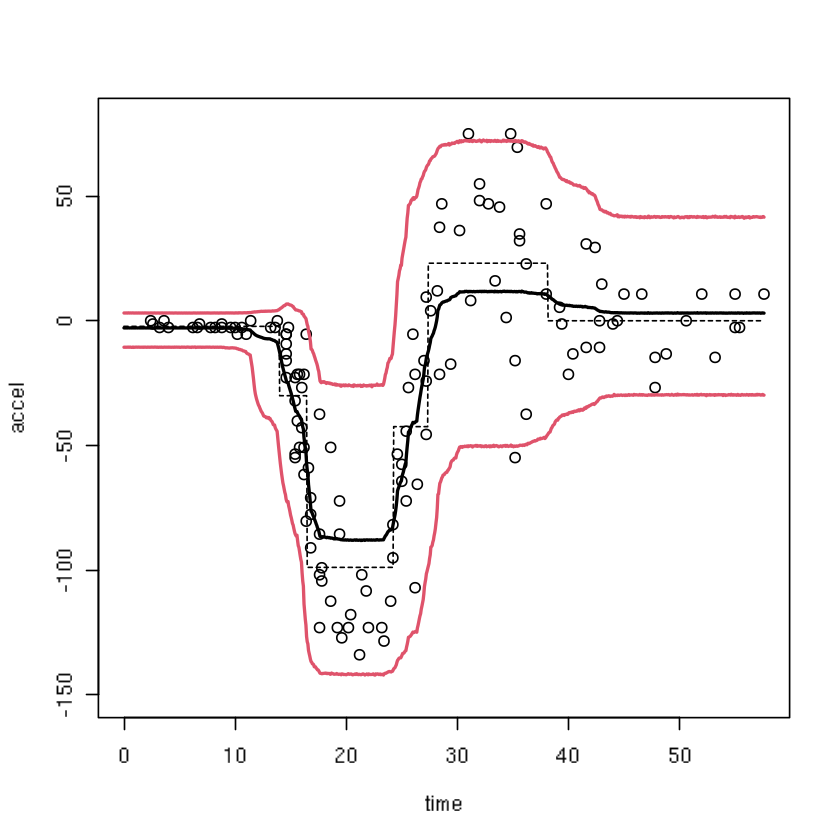

In [59]:
plot.moto(out.bcart, outp.bcart)

In [60]:
out.btlm <- btlm(X=mcycle[,1], Z=mcycle[,2], XX=XX, R=100, verb=0)
outp.btlm <- predict(out.btlm, XX=XX)

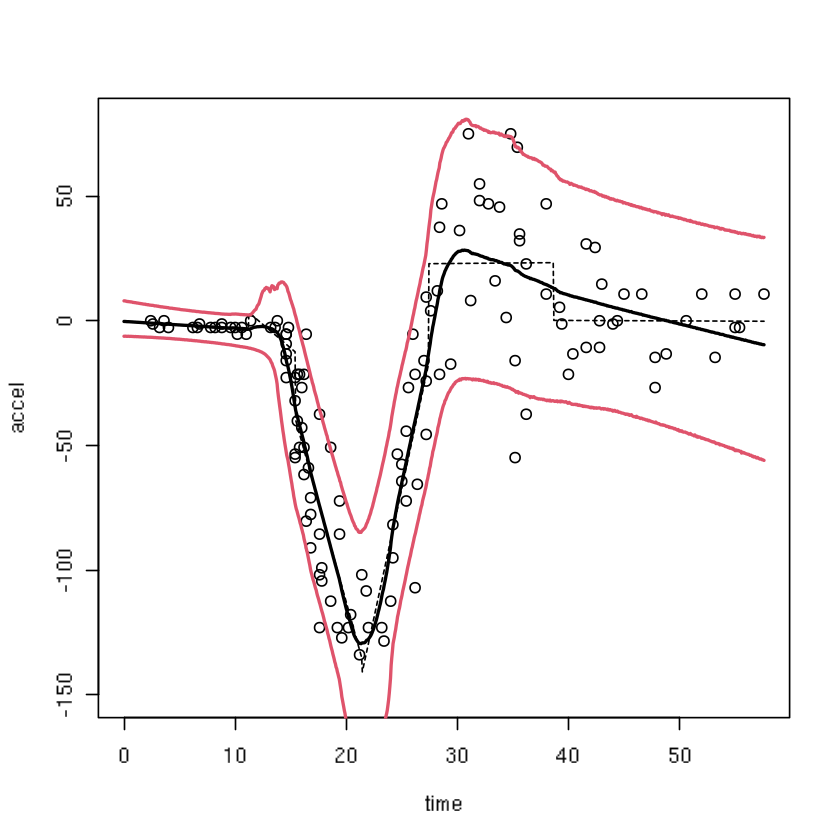

In [62]:
plot.moto(out.btlm, outp.btlm)

In [63]:
out.bgp <- bgp(X=mcycle[,1], Z=mcycle[,2], XX=XX, R=10, verb=0)
outp.bgp <- predict(out.bgp, XX=XX)

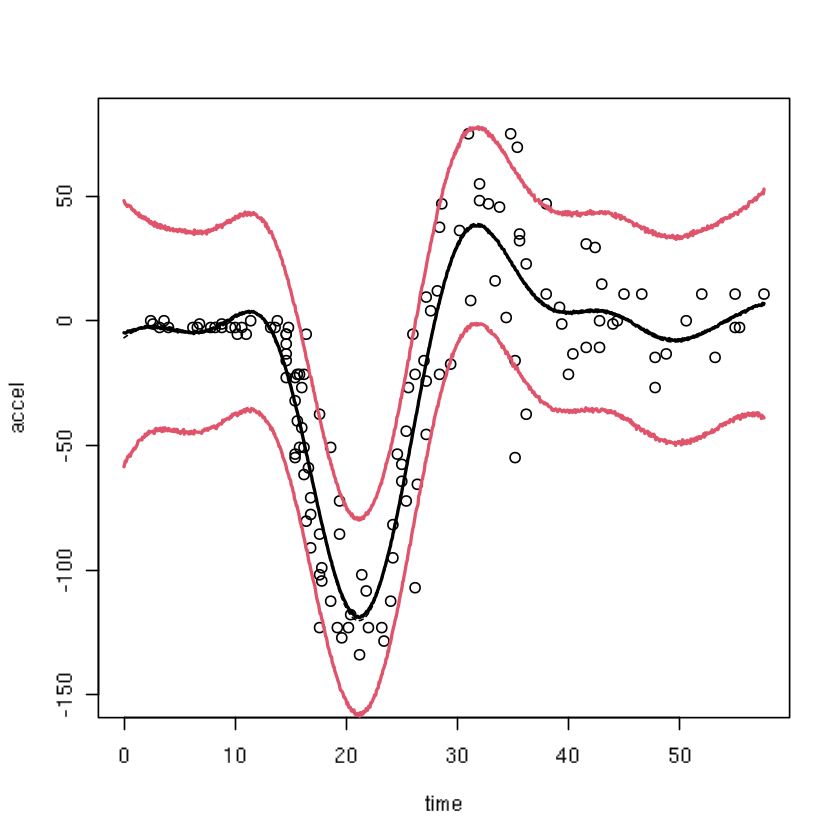

In [64]:
plot.moto(out.bgp, outp.bgp)

### 9.2.2 Treed Gaussian process

In [65]:
tic <- proc.time()[3]
out.btgp <- btgp(X=mcycle[,1], Z=mcycle[,2], XX=XX, R=30, 
  bprior="b0", verb=0)
toc <- proc.time()[3]
toc - tic

elapsed 
529.977

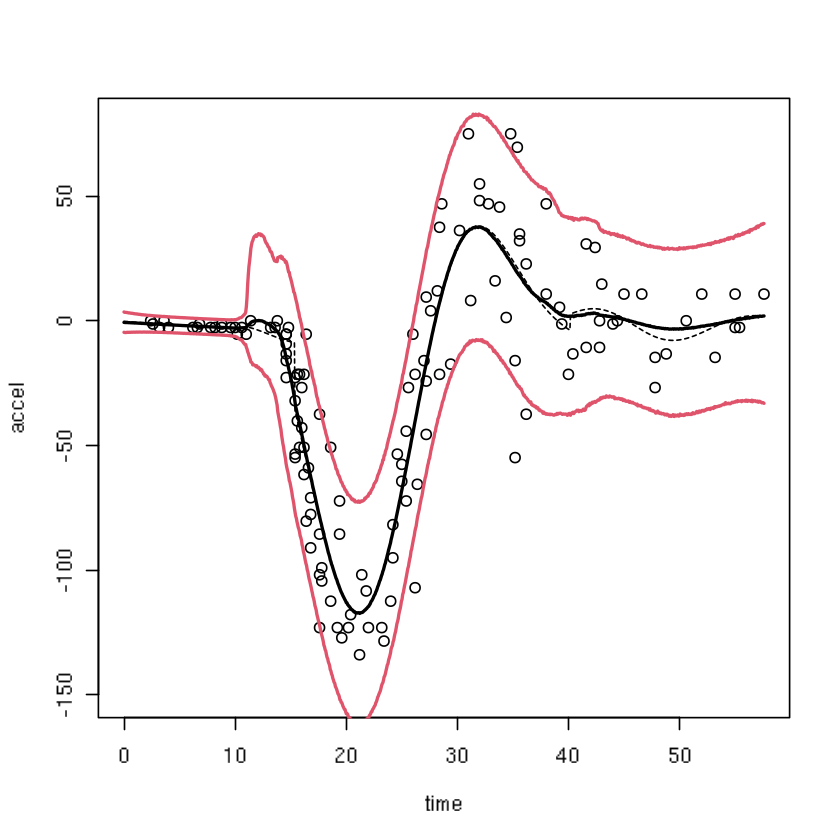

In [67]:
outp.btgp <- predict(out.btgp, XX=XX)
plot.moto(out.btgp, outp.btgp)

In [68]:
tic <- proc.time()[3]
out.btgpllm <- btgpllm(X=mcycle[,1], Z=mcycle[,2], XX=XX, R=30, 
  bprior="b0", verb=0)
outp.btgpllm <- predict(out.btgpllm, XX=XX)
toc <- proc.time()[3]
toc - tic

elapsed 
470.682

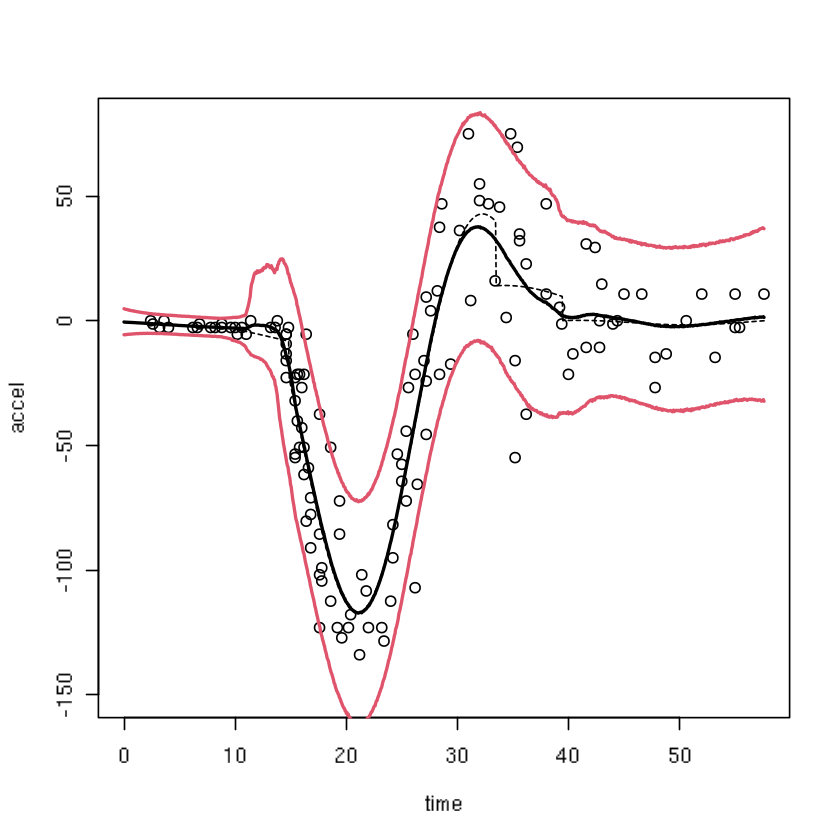

In [69]:
outp.btgpllm <- predict(out.btgpllm, XX=XX)
plot.moto(out.btgpllm, outp.btgpllm)

In [70]:
exp2d.data <- exp2d.rand(n1=30, n2=70)
X <- exp2d.data$X
Z <- exp2d.data$Z
XX <- exp2d.data$XX

In [71]:
out.bgp <- bgp(X=X, Z=Z, XX=XX, corr="exp", verb=0)

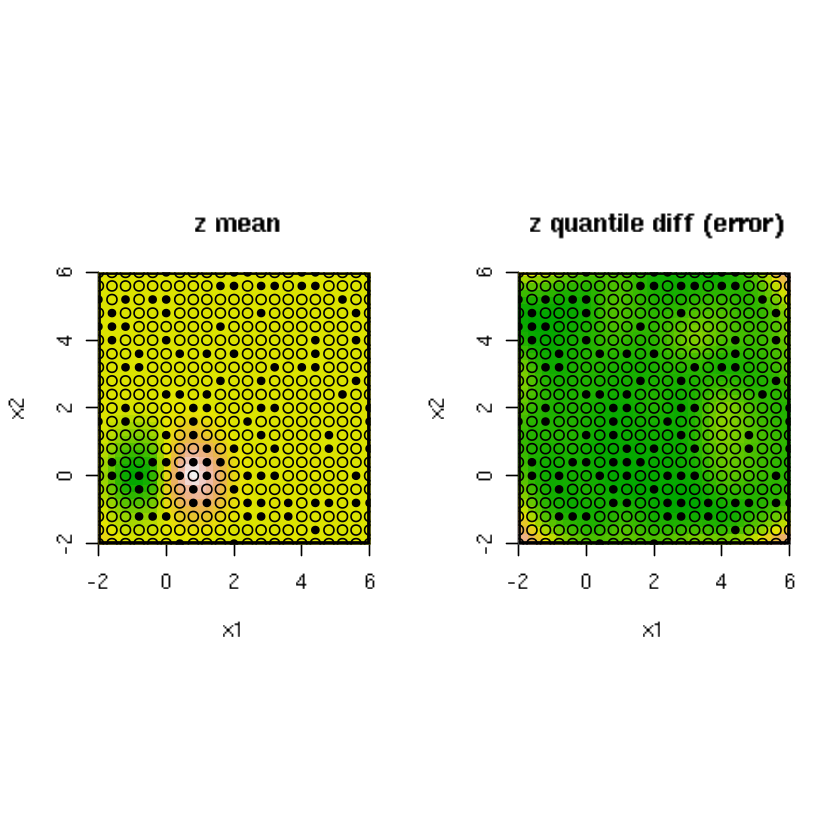

In [76]:
par(pty="s")
plot(out.bgp, pc="c")

In [73]:
out.btgp <- btgp(X=X, Z=Z, XX=XX, corr="exp", R=10, verb=0)

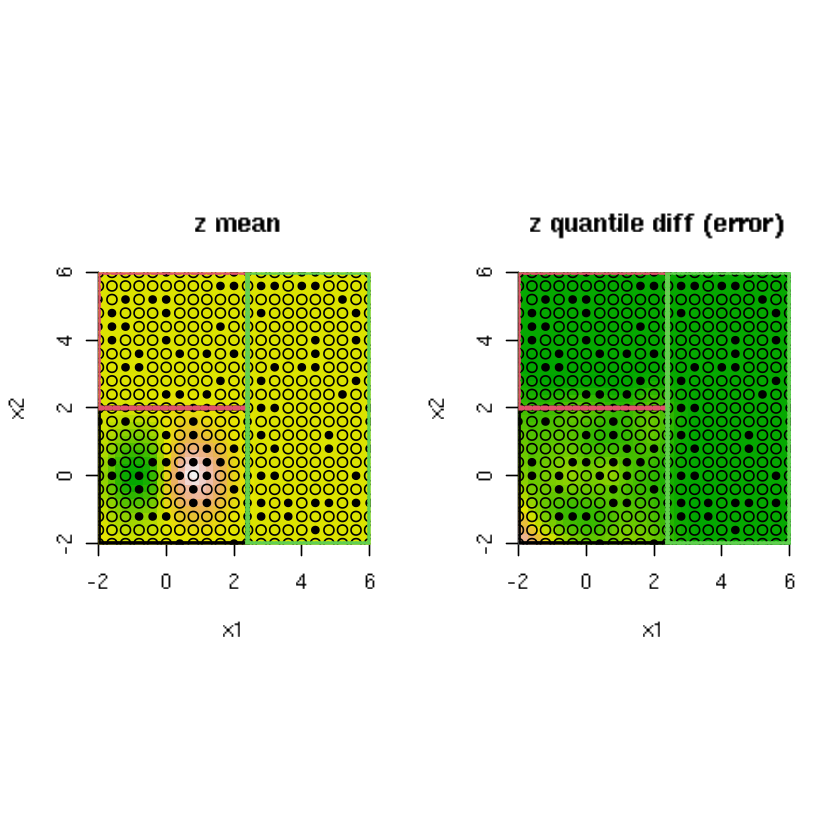

In [77]:
par(pty="s")
plot(out.btgp, pc="c")

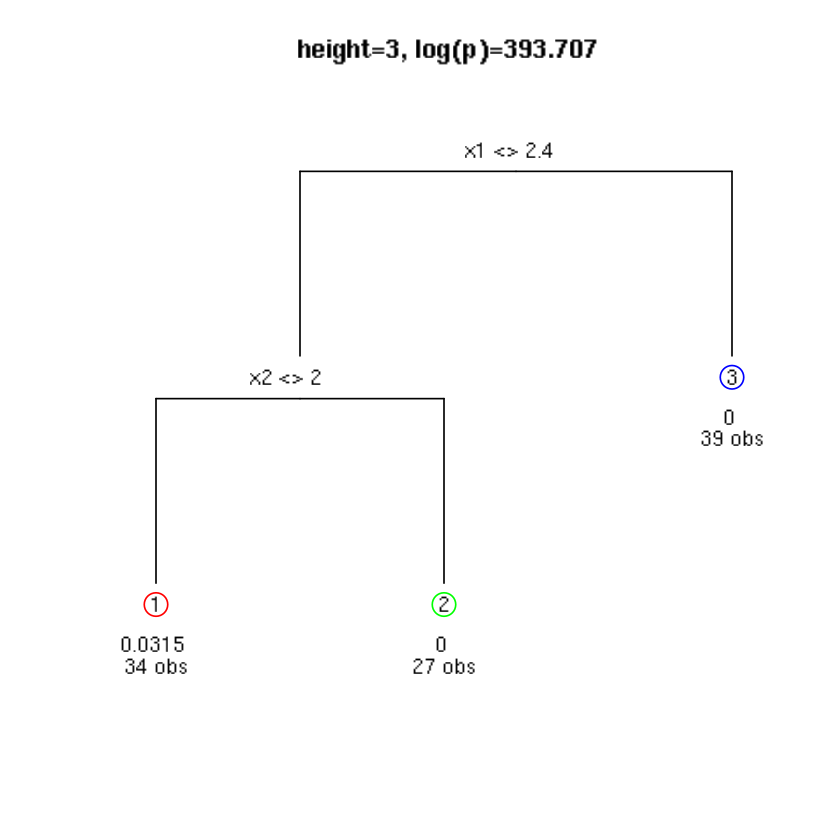

In [75]:
tgp.trees(out.btgp, heights="map")
